# ENSO Diversity

Calculate the diversity between Eastern and Central ENSO, based on first and second principal components.

This is based on the Cai 2018 method, with results for CMIP6 published in Wang 2020.


In [1]:
import sys
sys.path.append('../')

#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.timePeriod as tp
import utils.ecIndex as ec

In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


import climtas.nci

climtas.nci.GadiClient()

In [3]:
#load the full model set
modelSet=_model.scenarioMip

For all the models, calculate the alphas

%run wangsAlphas.py
#easiest to run on gadi

In [4]:
#multipliers determined through visual inspection to give a negative alpha
#sign is arbitrary in an EOF
multipliers={'ACCESS-CM2':[-1,1], 
    'ACCESS-ESM1-5':[-1,-1],
    'BCC-CSM2-MR':[1,1],
    'CAMS-CSM1-0':[1,1],
    'CAS-ESM2-0':[1,1],
    'CESM2':[1,1], 
    'CESM2-WACCM':[-1,1],
    'CIESM':[-1,1], 
    'CMCC-CM2-SR5':[-1,-1],
    'CMCC-ESM2':[-1,-1], 
    'CNRM-CM6-1':[1,1], 
    'CNRM-ESM2-1':[-1,-1], 
    'CanESM5':[-1,1],
    'CanESM5-CanOE':[1,1], 
    'EC-Earth3':[1,1], 
    'EC-Earth3-CC':[1,-1], 
    'EC-Earth3-Veg':[1,-1],
    'EC-Earth3-Veg-LR':[1,-1], 
    'FIO-ESM-2-0':[-1,1],
    'GFDL-CM4':[1,1], 
    'GFDL-ESM4':[1,-1], 
    'GISS-E2-1-G':[-1,-1],
    'HadGEM3-GC31-LL':[1,1], 
    'HadGEM3-GC31-MM':[1,1], 
    'INM-CM4-8':[-1,1], 
    'INM-CM5-0':[1,-1],
    'IPSL-CM6A-LR':[-1,-1], 
    'KACE-1-0-G':[1,-1], 
    'MCM-UA-1-0':[-1,-1], 
    'MIROC-ES2L':[-1,1], 
    'MIROC6':[1,-1],
    'MPI-ESM1-2-HR':[1,1], 
    'MPI-ESM1-2-LR':[-1,1],
    'MRI-ESM2-0':[1,1], 
    'NESM3':[-1,1],
    'NorESM2-LM':[-1,-1], 
    'NorESM2-MM':[1,-1], 
    'UKESM1-0-LL':[1,1] 
    }

ACCESS-CM2
[-1, 1]


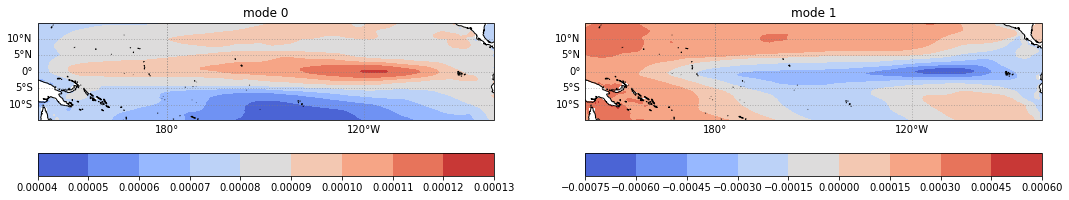

-0.003256403177574215  ....  0.2339329978409227


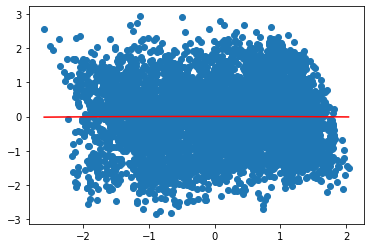

ACCESS-ESM1-5
[-1, -1]


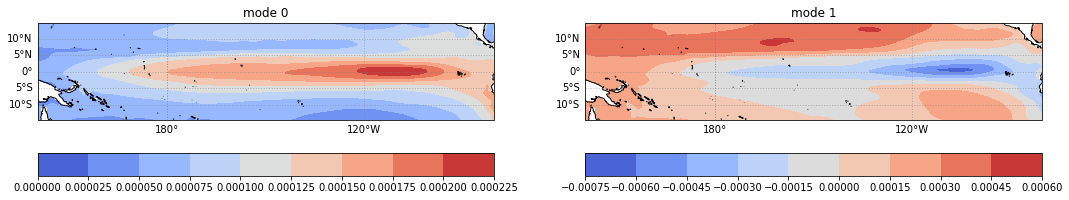

-0.11332341823775831  ....  0.1508368308764101


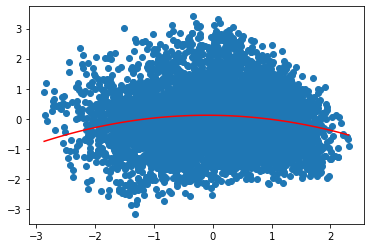

BCC-CSM2-MR
[1, 1]


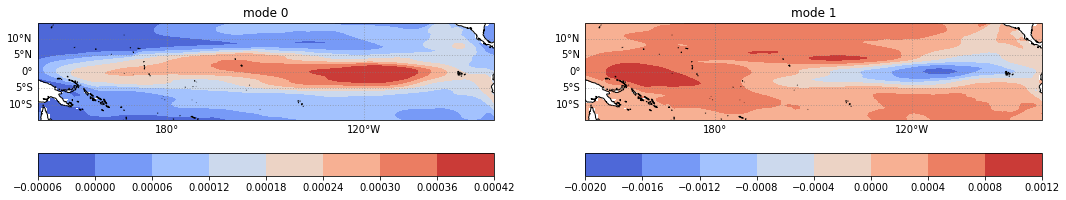

-0.07497346960680888  ....  -0.05803845248904753


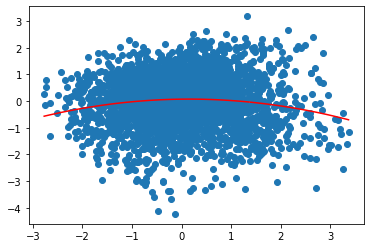

CAMS-CSM1-0
[1, 1]


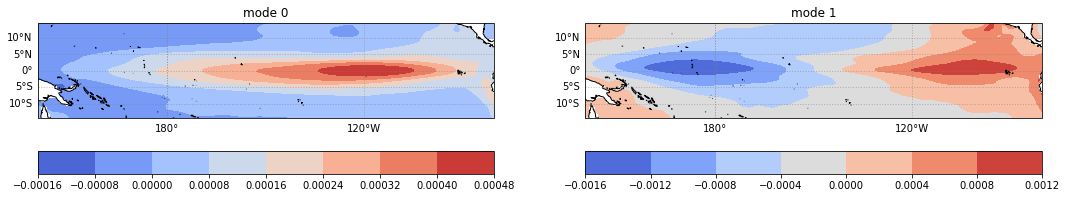

-0.2657441705277164  ....  0.4334009916939109


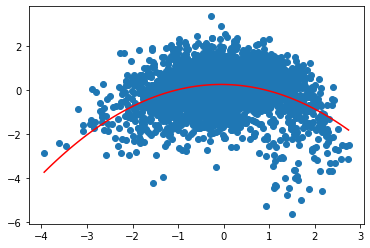

CAS-ESM2-0
[1, 1]


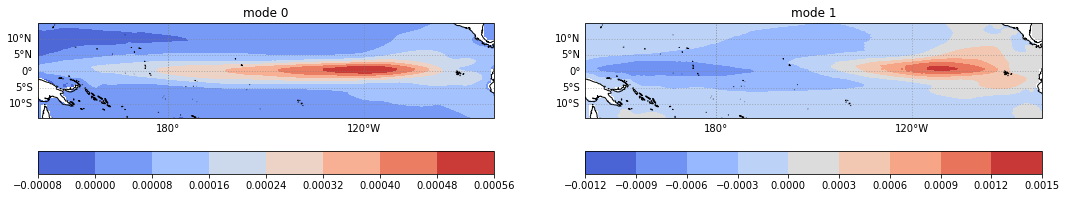

-0.21635491008913924  ....  0.430004678110751


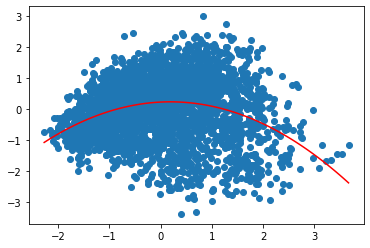

CESM2
[1, 1]


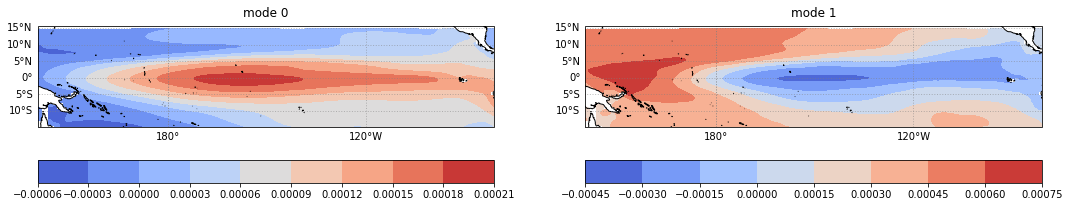

-0.29530808015911386  ....  -0.4378474224092391


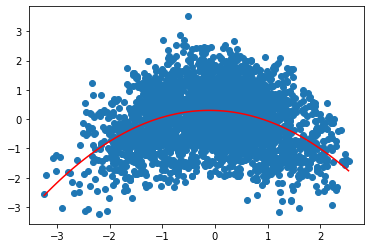

CESM2-WACCM
[-1, 1]


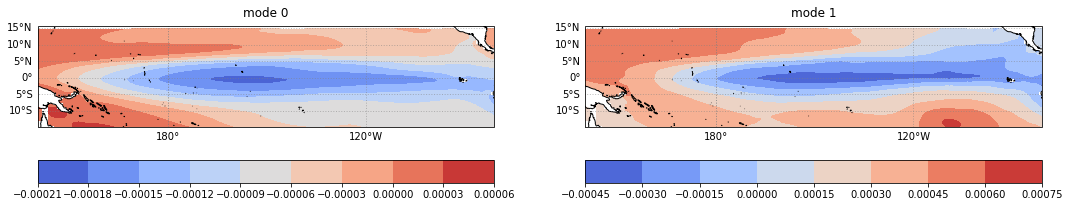

-0.20264739515272356  ....  -0.28254437418557415


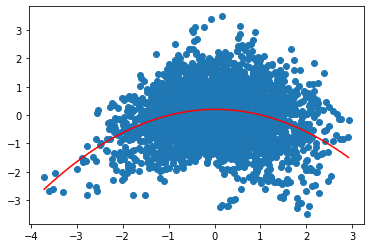

CIESM
[-1, 1]


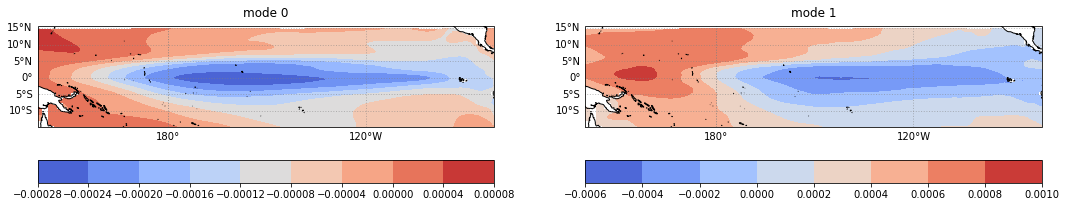

-0.22535529499973253  ....  -0.4854799794841226


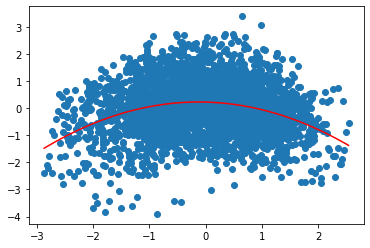

CMCC-CM2-SR5
[-1, -1]


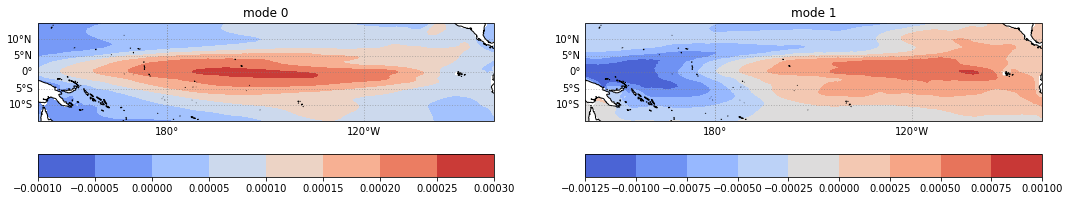

-0.36880515248264273  ....  -0.677640838497084


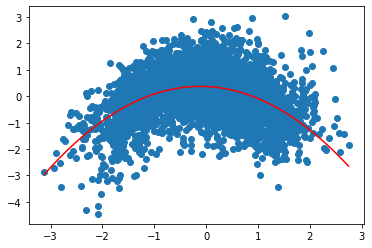

CMCC-ESM2
[-1, -1]


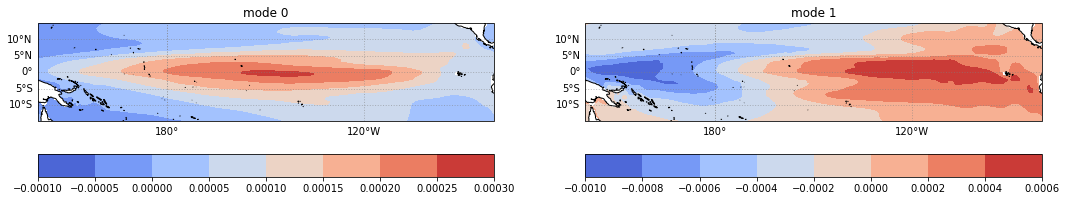

-0.39837649805945086  ....  -0.6790144598575915


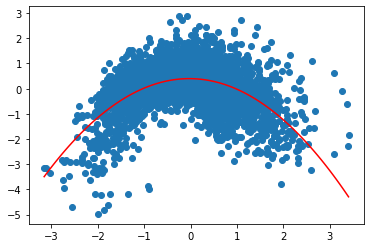

CNRM-CM6-1
[1, 1]


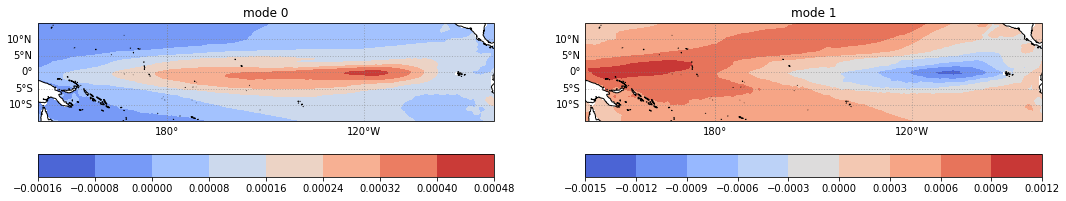

-0.16248594028424315  ....  -0.302855814843159


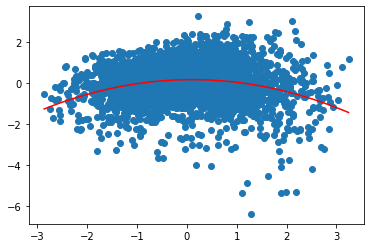

CNRM-ESM2-1
[-1, -1]


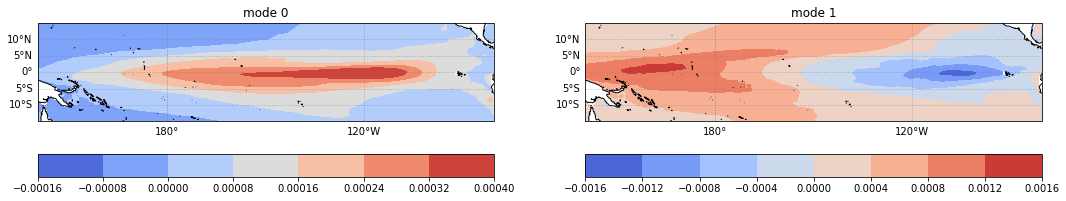

-0.1184967334856125  ....  0.3041707325225422


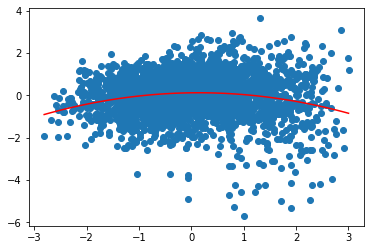

CanESM5
[-1, 1]


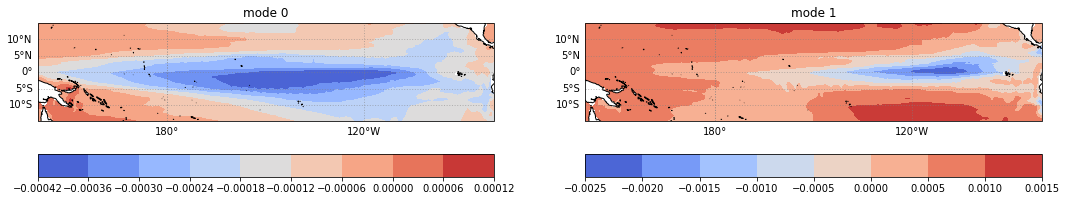

-0.007198146201488556  ....  0.021370245513439967


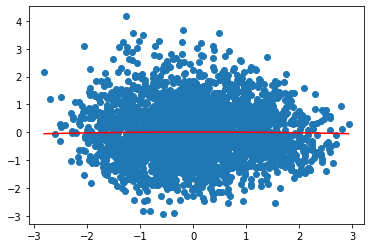

CanESM5-CanOE
[1, 1]


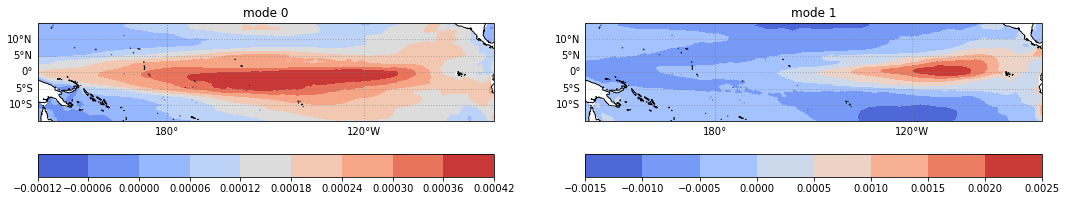

-0.05068739271794808  ....  0.03798600091097855


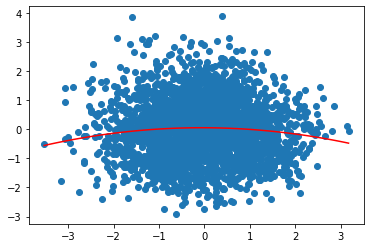

EC-Earth3
[1, 1]


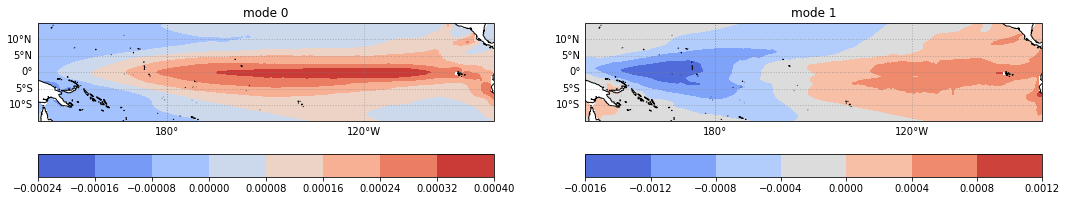

-0.21096017577142911  ....  0.49204673355305883


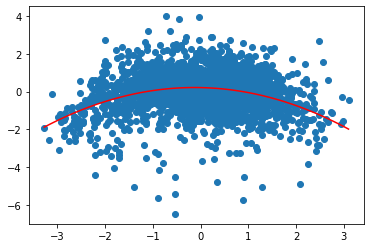

EC-Earth3-CC
[1, -1]


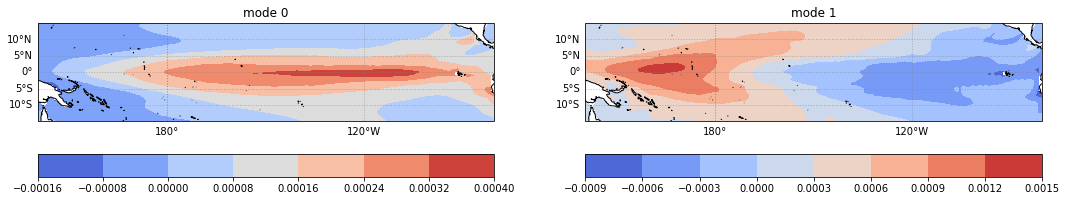

-0.25749718636222213  ....  0.5624282911038797


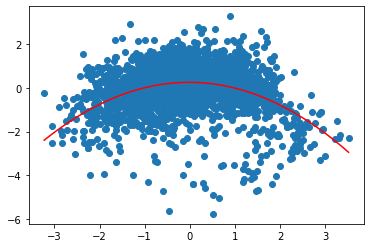

EC-Earth3-Veg
[1, -1]


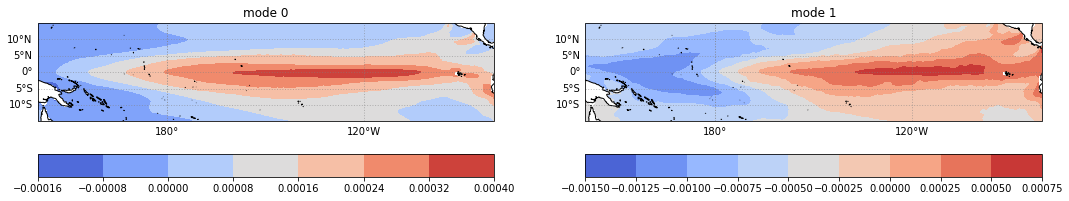

-0.20276733887914458  ....  -0.4007737752358283


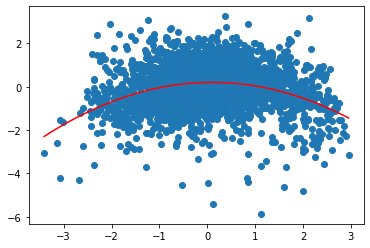

EC-Earth3-Veg-LR
[1, -1]


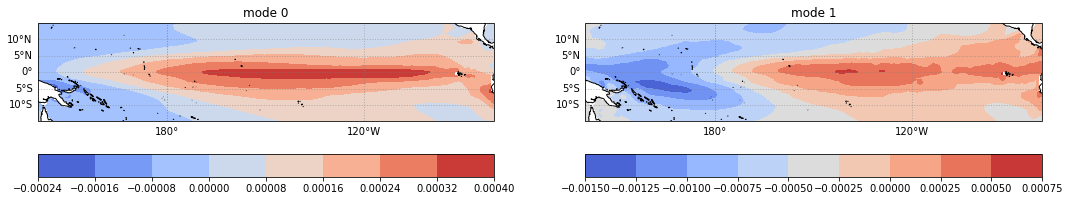

-0.21745242815947663  ....  -0.4540694536364493


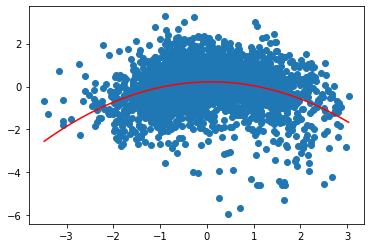

FIO-ESM-2-0
[-1, 1]
'DataArray' object has no attribute 'lon'
GFDL-CM4
[1, 1]


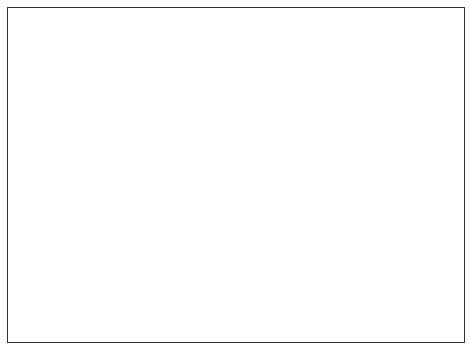

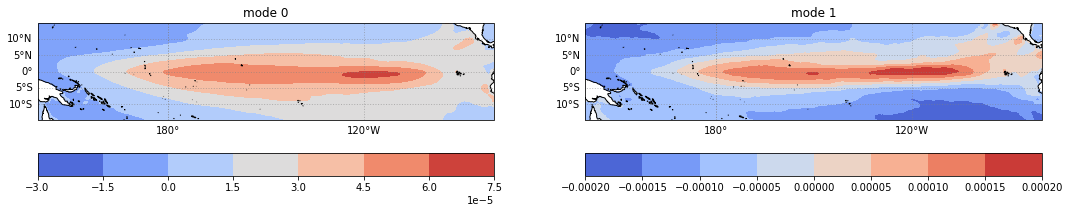

-0.10033381262648698  ....  0.05633732733054477


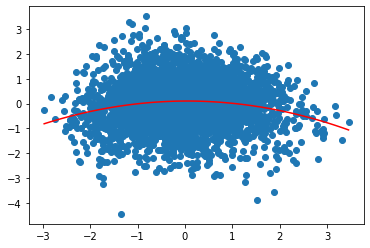

GFDL-ESM4
[1, -1]


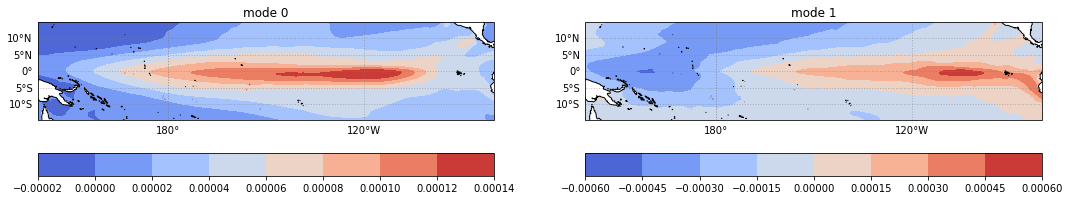

-0.16445774964918017  ....  -0.38164935020899854


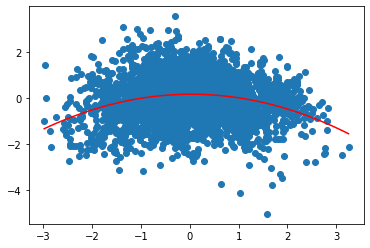

GISS-E2-1-G
[-1, -1]


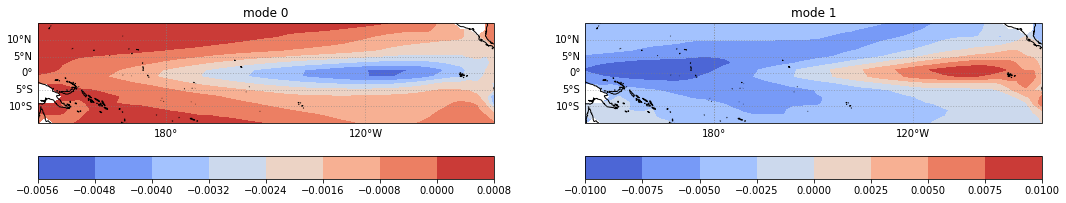

-0.34622671738144484  ....  -0.44702815689251335


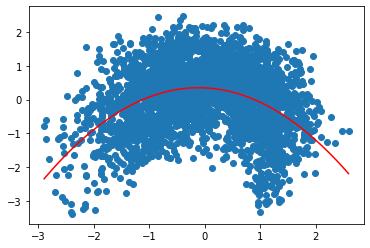

HadGEM3-GC31-LL
[1, 1]


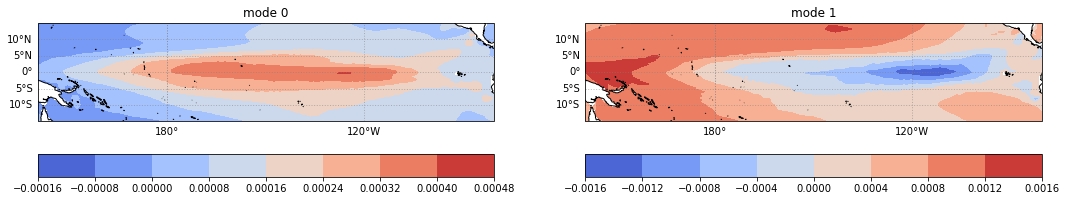

-0.1624136346277161  ....  -0.2823338347533916


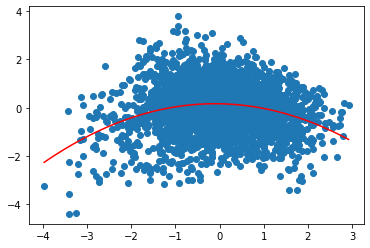

HadGEM3-GC31-MM
[Errno 2] No such file or directory: b'/home/603/as2285/compound/prelim/results/wangAlphas/indexHadGEM3-GC31-MM.nc'
INM-CM4-8
[-1, 1]


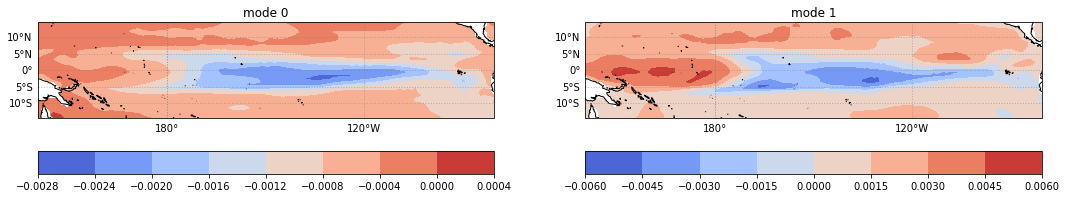

-0.01976044704576649  ....  -0.043229523592320865


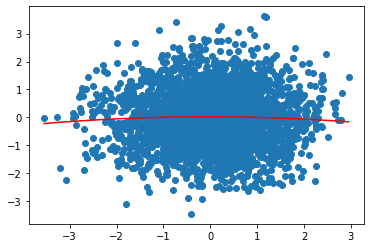

INM-CM5-0
[1, -1]


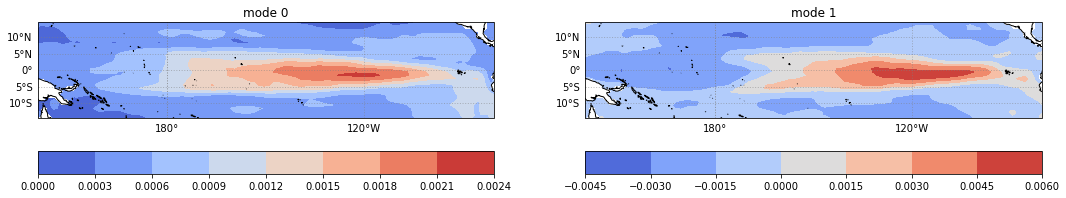

-0.0022883254620233414  ....  -0.0019329289347128473


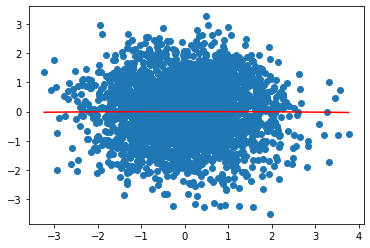

IPSL-CM6A-LR
[-1, -1]


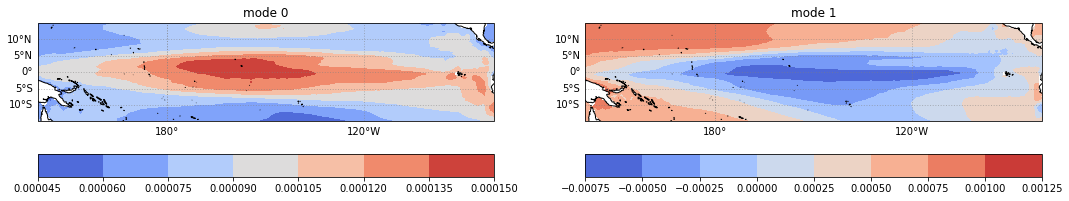

-0.010578530220723617  ....  0.039740071186103294


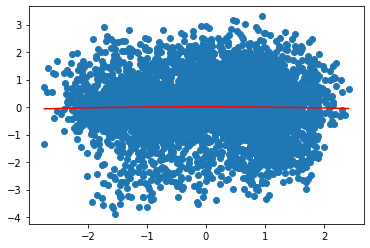

KACE-1-0-G
[1, -1]


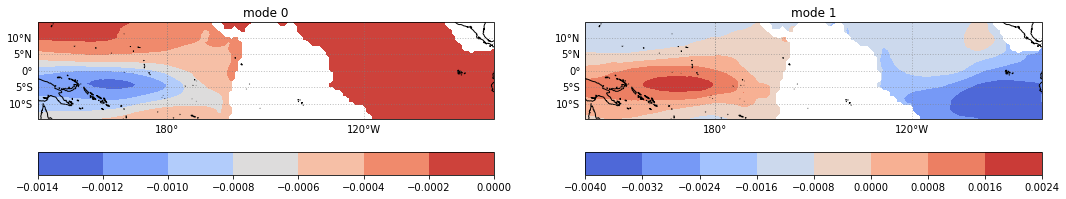

-0.01076329851881817  ....  0.024141921621324402


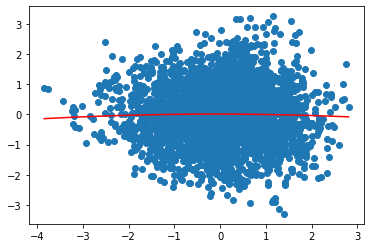

MCM-UA-1-0
[-1, -1]


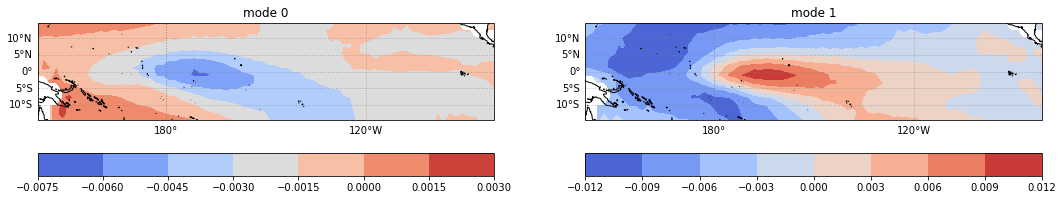

-0.25919725164544477  ....  -0.35463133344060743


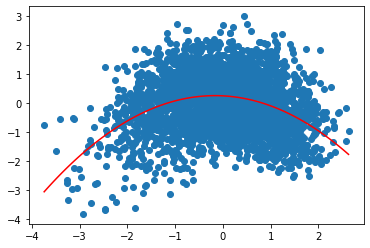

MIROC-ES2L
[-1, 1]


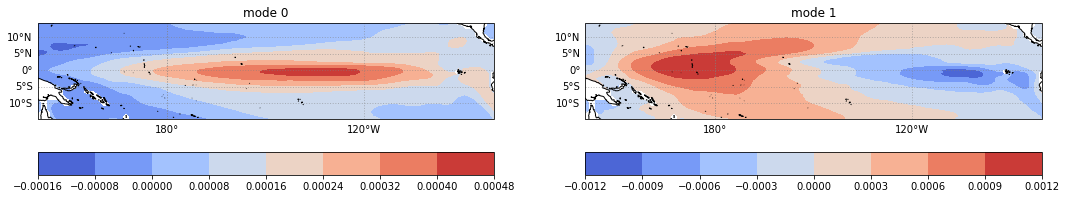

-0.31804277730994285  ....  -0.7916354705044364


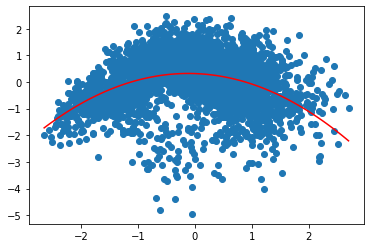

MIROC6
[1, -1]


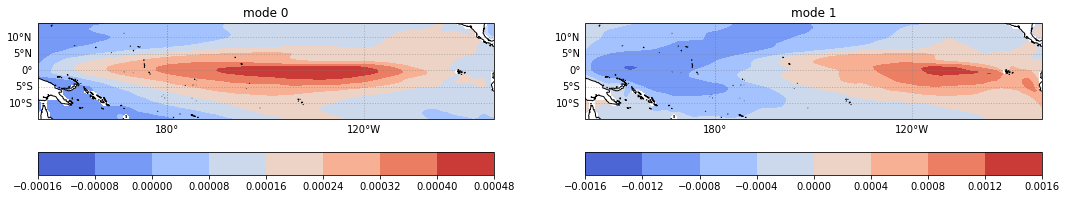

-0.32279744416690076  ....  -0.6085549527029757


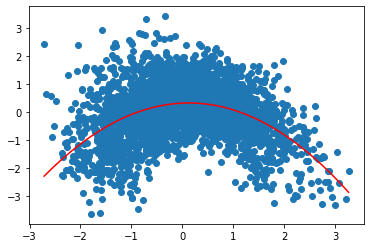

MPI-ESM1-2-HR
[1, 1]


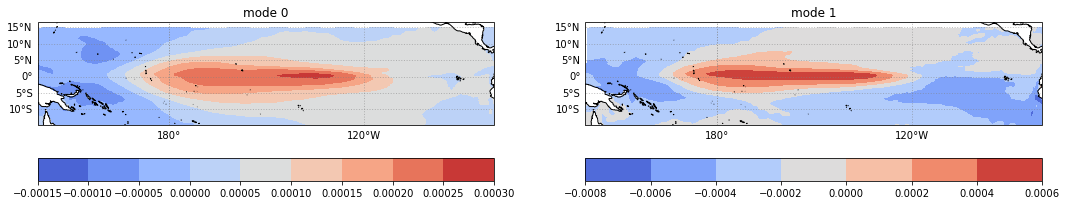

-0.1080016986943235  ....  0.0061960126397698


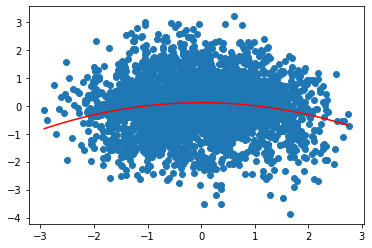

MPI-ESM1-2-LR
[-1, 1]


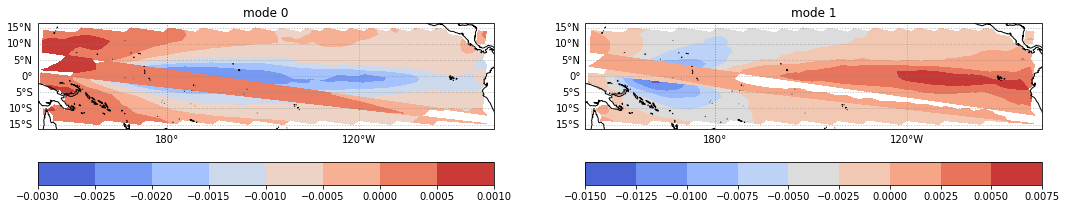

-0.1915663715893127  ....  0.5057613771605379


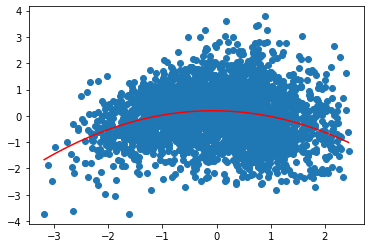

MRI-ESM2-0
[1, 1]


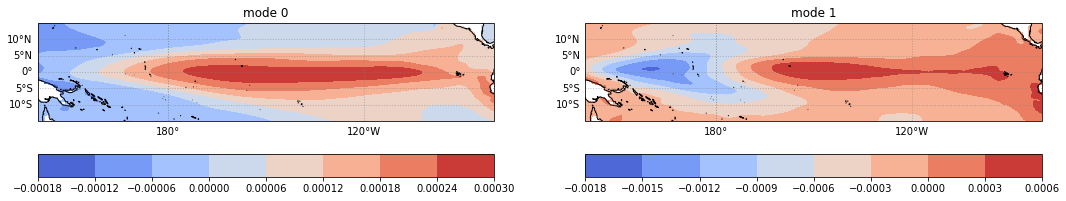

-0.3469949736502555  ....  0.6280817446807483


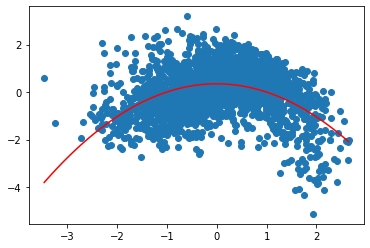

NESM3
[-1, 1]


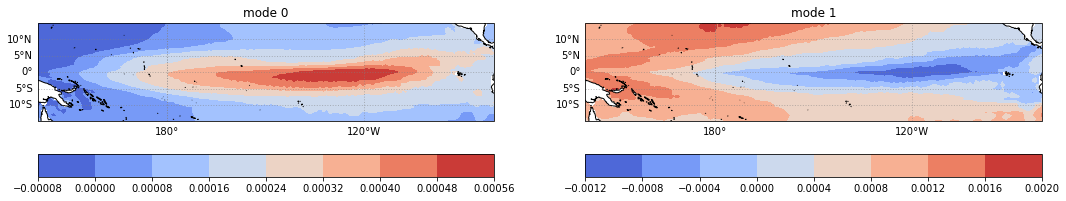

-0.02350450616627606  ....  -0.11266971569510656


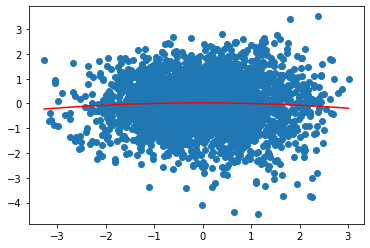

NorESM2-LM
[-1, -1]


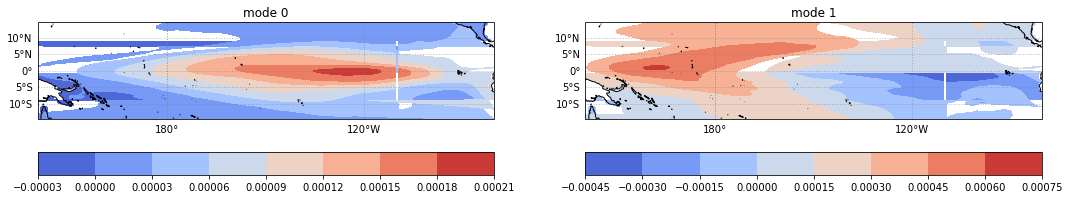

-0.25511264614008466  ....  0.5250861508143696


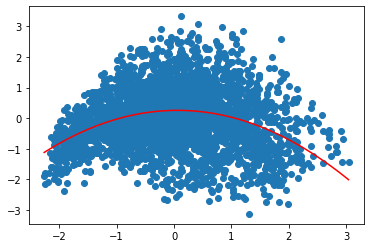

NorESM2-MM
[1, -1]


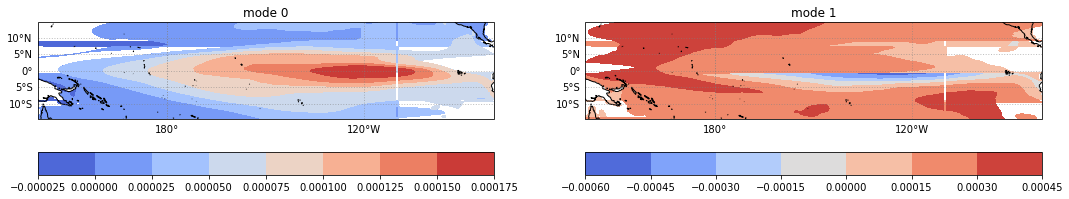

-0.22892777065217262  ....  0.2991572682737709


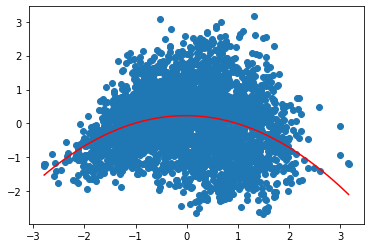

UKESM1-0-LL
[1, 1]


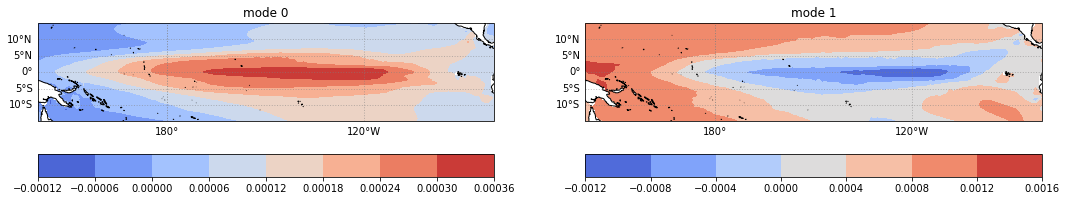

-0.14146362039674276  ....  -0.2585694245080954


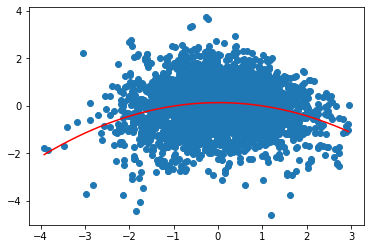

In [5]:
alphas=dict()

for iModel in modelSet:
    import numpy.polynomial as poly
    try:
        print(iModel[1])
        
        indeces=xarray.load_dataset('results/wangAlphas/index'+str(iModel[1])+'.nc')
        eofsXr=xarray.load_dataarray('results/wangAlphas/eof'+str(iModel[1])+'.nc')
        
        alpha=float(indeces.alpha.values)
        
        multiplyBy=multipliers[iModel[1]]
        
        print(multiplyBy)
        
        pc1=multiplyBy[0]*indeces.pc1
        pc2=multiplyBy[1]*indeces.pc2
        pFit = poly.Polynomial.fit(pc1, pc2, 2)
        alpha = pFit.convert().coef[2]
        
        fig=plt.figure(figsize=(18,12))
        
        for mode in [0,1]:
            ax=fig.add_subplot(1,2,mode+1,
                           projection=ccrs.Miller(central_longitude=210))

            ec.ensoPlotter(multiplyBy[mode]*eofsXr.sel(mode=mode), ax)

            plt.title("mode " + str(mode))

        plt.show()

        print(str(alpha)+'  ....  ' + str(indeces.alphaDjf.values))
        alphas[iModel[1]]=alpha
        
        plt.scatter(pc1, pc2)

        plt.plot(*pFit.linspace(), 'r')
        
        plt.show()
    except Exception as e:
        print(e)
    

This is the models which have alpha less than -0.15 from the Wang 2020

In [6]:
wangsAnswers={'CAMS-CSM1-0':-0.2902, 
    'CMCC-CM2-SR5':-0.4055, 
    'CNRM-CM6-1':-0.1662, 
    'CNRM-ESM2-1':-0.1687,
    'EC-Earth3':-0.2662, 
    'EC-Earth3-Veg':-0.2665, 
    'FIO-ESM-2-0':-0.3751,
    'MIROC6':-0.3198, 
    'MIROC-ES2L': -0.3466,
    'HadGEM3-GC31-LL':-0.1785, 
    'MPI-ESM1-2-HR':-0.2660, 
    'MPI-ESM1-2-LR':-0.2338, 
    'MRI-ESM2-0':-0.3387,
    'GISS-E2-1-G':-0.3644, 
    'CESM2':-0.3216, 
    'CESM2-WACCM':-0.2436, 
    'NorESM2-LM':-0.2505, 
    'NorESM2-MM':-.2077,
    'GFDL-ESM4':-.1931, 
    'CIESM':-.1886, 
    'MCM-UA-1-0':-0.2888}

In [7]:
print('model         calculated           expected')
for iModel in wangsAnswers.keys():
    try:
        print(str(iModel) + ' : ' + str(alphas[iModel]) + '   ' + str(wangsAnswers[iModel]))
    except:
        print(str(iModel) + ' results not found')

model         calculated           expected
CAMS-CSM1-0 : -0.2657441705277164   -0.2902
CMCC-CM2-SR5 : -0.36880515248264273   -0.4055
CNRM-CM6-1 : -0.16248594028424315   -0.1662
CNRM-ESM2-1 : -0.1184967334856125   -0.1687
EC-Earth3 : -0.21096017577142911   -0.2662
EC-Earth3-Veg : -0.20276733887914458   -0.2665
FIO-ESM-2-0 results not found
MIROC6 : -0.32279744416690076   -0.3198
MIROC-ES2L : -0.31804277730994285   -0.3466
HadGEM3-GC31-LL : -0.1624136346277161   -0.1785
MPI-ESM1-2-HR : -0.1080016986943235   -0.266
MPI-ESM1-2-LR : -0.1915663715893127   -0.2338
MRI-ESM2-0 : -0.3469949736502555   -0.3387
GISS-E2-1-G : -0.34622671738144484   -0.3644
CESM2 : -0.29530808015911386   -0.3216
CESM2-WACCM : -0.20264739515272356   -0.2436
NorESM2-LM : -0.25511264614008466   -0.2505
NorESM2-MM : -0.22892777065217262   -0.2077
GFDL-ESM4 : -0.16445774964918017   -0.1931
CIESM : -0.22535529499973253   -0.1886
MCM-UA-1-0 : -0.25919725164544477   -0.2888


In [8]:
for iModel in wangsAnswers.keys():
        try:
            if alphas[iModel]<-0.15:
                print(iModel + ' matched: ' + str(alphas[iModel]) + '  ' + str(wangsAnswers[iModel]))
            else:
                print(iModel + ' not matched: ' + str(alphas[iModel]) + '  ' + str(wangsAnswers[iModel]))
        except:
            print(iModel + ' not matched')

CAMS-CSM1-0 matched: -0.2657441705277164  -0.2902
CMCC-CM2-SR5 matched: -0.36880515248264273  -0.4055
CNRM-CM6-1 matched: -0.16248594028424315  -0.1662
CNRM-ESM2-1 not matched: -0.1184967334856125  -0.1687
EC-Earth3 matched: -0.21096017577142911  -0.2662
EC-Earth3-Veg matched: -0.20276733887914458  -0.2665
FIO-ESM-2-0 not matched
MIROC6 matched: -0.32279744416690076  -0.3198
MIROC-ES2L matched: -0.31804277730994285  -0.3466
HadGEM3-GC31-LL matched: -0.1624136346277161  -0.1785
MPI-ESM1-2-HR not matched: -0.1080016986943235  -0.266
MPI-ESM1-2-LR matched: -0.1915663715893127  -0.2338
MRI-ESM2-0 matched: -0.3469949736502555  -0.3387
GISS-E2-1-G matched: -0.34622671738144484  -0.3644
CESM2 matched: -0.29530808015911386  -0.3216
CESM2-WACCM matched: -0.20264739515272356  -0.2436
NorESM2-LM matched: -0.25511264614008466  -0.2505
NorESM2-MM matched: -0.22892777065217262  -0.2077
GFDL-ESM4 matched: -0.16445774964918017  -0.1931
CIESM matched: -0.22535529499973253  -0.1886
MCM-UA-1-0 matched: -

Those results are broadly similar. 


Except:
MRI-ESM2-0 : -0.08754060648965808   -0.3387 ??




# Full example /sandbox

Climatology and piControl:

In [9]:
for iModel in [modelSet[33]]:
    
    print(iModel)
    
    try: 
            
        #to replicate Wang 2020
        tsXr = xarray.concat([fh.loadModelData(iModel[1], 'tos_Omon', 'historical', iModel[3], 
                                               chunks={'time':120}).tos, 
                              fh.loadModelData(iModel[1], 'tos_Omon', 'ssp585', iModel[3], 
                                               chunks={'time':120}).tos], 
                             dim='time')

        #tsXr = tsXr.where((tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
        #    drop=True)

        
    except Exception as e:
        print(iModel[1] + "Climatology did not calculate")
        print(e)
 

['MRI' 'MRI-ESM2-0' 'r1i1p1f1_gn' 'r1i1p1f1_gn']
['/g/data/oi10/replicas/CMIP6/CMIP//MRI/MRI-ESM2-0/historical/r1i1p1f1/Omon/tos/gn/v20190904/tos_Omon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc']
['/g/data/oi10/replicas/CMIP6/ScenarioMIP//MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Omon/tos/gn/v20191108/tos_Omon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_210101-230012.nc', '/g/data/oi10/replicas/CMIP6/ScenarioMIP//MRI/MRI-ESM2-0/ssp585/r1i1p1f1/Omon/tos/gn/v20191108/tos_Omon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_201501-210012.nc']


In [10]:
tsXr.lon

<xarray.DataArray 'lon' (y: 363, x: 360)>
array([[80.        , 81.        , 82.        , ..., 77.        ,
        78.        , 79.        ],
       [80.        , 81.        , 82.        , ..., 77.        ,
        78.        , 79.        ],
       [80.        , 81.        , 82.        , ..., 77.        ,
        78.        , 79.        ],
       ...,
       [80.        , 80.07549286, 80.15103149, ..., 79.77333832,
        79.84896851, 79.92450714],
       [80.        , 80.03778839, 80.07559967, ..., 79.8865509 ,
        79.92440033, 79.96221161],
       [80.        , 80.        , 80.        , ..., 80.        ,
        80.        , 80.        ]])
Coordinates:
  * y        (y) float64 -78.0 -77.5 -77.0 -76.5 ... 147.5 149.7 151.8 154.0
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    lat      (y, x) float64 -78.0 -78.0 -78.0 -78.0 ... 65.7 65.29 64.86 64.43
    lon      (y, x) float64 80.0 81.0 82.0 83.0 84.0 ... 80.0 80.0 80.0 80.0

Cut it into the area of interest

In [11]:
tsXr=tsXr.where(
    (tsXr.lat>=-15) & (tsXr.lat<=15) &
    (tsXr.lon>=140) & (tsXr.lon<=280),
    drop=True
)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [12]:
tsXr

<xarray.DataArray 'tos' (time: 5412, y: 87, x: 141)>
dask.array<where, shape=(5412, 87, 141), dtype=float32, chunksize=(120, 87, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 00:00:00 ... 2300-12-16 00:00:00
  * y        (y) float64 -15.0 -14.5 -14.0 -13.5 -13.0 ... 13.5 14.0 14.5 15.0
  * x        (x) float64 60.0 61.0 62.0 63.0 64.0 ... 197.0 198.0 199.0 200.0
    lat      (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... 15.0 15.0 15.0 15.0
    lon      (y, x) float64 140.0 141.0 142.0 143.0 ... 277.0 278.0 279.0 280.0
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-09-03T06:33:16Z altered by CMOR: replaced missing va...

In [13]:
tsXr=tsXr.where(
    (tsXr.time.dt.year>=1900) * (tsXr.time.dt.year<2100), 
    drop=True
)


In [14]:
tsXr 

<xarray.DataArray 'tos' (time: 2400, y: 87, x: 141)>
dask.array<where, shape=(2400, 87, 141), dtype=float32, chunksize=(120, 87, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * y        (y) float64 -15.0 -14.5 -14.0 -13.5 -13.0 ... 13.5 14.0 14.5 15.0
  * x        (x) float64 60.0 61.0 62.0 63.0 64.0 ... 197.0 198.0 199.0 200.0
    lat      (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... 15.0 15.0 15.0 15.0
    lon      (y, x) float64 140.0 141.0 142.0 143.0 ... 277.0 278.0 279.0 280.0
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-09-03T06:33:16Z altered by CMOR: replaced missing va...

In [15]:
from eofs.xarray import Eof



In [16]:
trendXr = tsXr.polyfit('time', 2)

In [17]:
trendXr

<xarray.Dataset>
Dimensions:               (degree: 3, x: 141, y: 87)
Coordinates:
  * degree                (degree) int64 2 1 0
  * y                     (y) float64 -15.0 -14.5 -14.0 -13.5 ... 14.0 14.5 15.0
  * x                     (x) float64 60.0 61.0 62.0 63.0 ... 198.0 199.0 200.0
Data variables:
    polyfit_coefficients  (degree, y, x) float64 dask.array<chunksize=(3, 87, 141), meta=np.ndarray>

In [18]:
trendXr = xarray.polyval(tsXr.time, trendXr.polyfit_coefficients, 'degree')


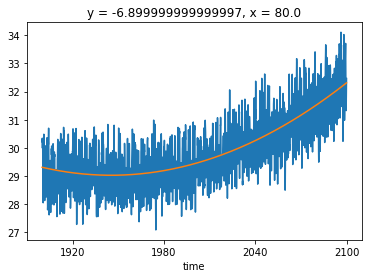

In [19]:
tsXr.isel(y=20,x=20).plot()
trendXr.isel(y=20,x=20).plot()

In [20]:
detrendXr=tsXr-trendXr

In [21]:
detrendXr

<xarray.DataArray (time: 2400, y: 87, x: 141)>
dask.array<sub, shape=(2400, 87, 141), dtype=float64, chunksize=(120, 87, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * y        (y) float64 -15.0 -14.5 -14.0 -13.5 -13.0 ... 13.5 14.0 14.5 15.0
  * x        (x) float64 60.0 61.0 62.0 63.0 64.0 ... 197.0 198.0 199.0 200.0
    lat      (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... 15.0 15.0 15.0 15.0
    lon      (y, x) float64 140.0 141.0 142.0 143.0 ... 277.0 278.0 279.0 280.0

In [22]:
sstMeanXr=detrendXr.where((detrendXr.time.dt.year>=1900) * (detrendXr.time.dt.year<2000), 
            drop=True).groupby('time.month').mean(dim='time')

In [23]:
sstMeanXr

<xarray.DataArray (month: 12, y: 87, x: 141)>
dask.array<stack, shape=(12, 87, 141), dtype=float64, chunksize=(1, 87, 141), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -15.0 -14.5 -14.0 -13.5 -13.0 ... 13.5 14.0 14.5 15.0
  * x        (x) float64 60.0 61.0 62.0 63.0 64.0 ... 197.0 198.0 199.0 200.0
    lat      (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... 15.0 15.0 15.0 15.0
    lon      (y, x) float64 140.0 141.0 142.0 143.0 ... 277.0 278.0 279.0 280.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [24]:
sstAnomXr=detrendXr.groupby('time.month')-sstMeanXr

In [25]:
sstAnomXr

<xarray.DataArray (time: 2400, y: 87, x: 141)>
dask.array<getitem, shape=(2400, 87, 141), dtype=float64, chunksize=(1, 87, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * y        (y) float64 -15.0 -14.5 -14.0 -13.5 -13.0 ... 13.5 14.0 14.5 15.0
  * x        (x) float64 60.0 61.0 62.0 63.0 64.0 ... 197.0 198.0 199.0 200.0
    lat      (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... 15.0 15.0 15.0 15.0
    lon      (y, x) float64 140.0 141.0 142.0 143.0 ... 277.0 278.0 279.0 280.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


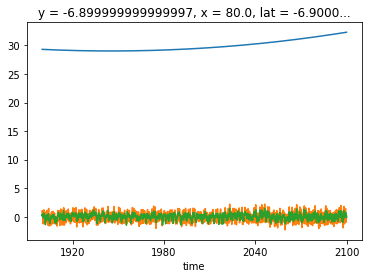

In [26]:

trendXr.isel(y=20,x=20).plot()

detrendXr.isel(y=20,x=20).plot()

sstAnomXr.isel(y=20,x=20).plot()

In [27]:
import cartopy.crs as ccrs


In [28]:
#there seems to be a bug in the Eof solver that doesn't handle dask very well,so pre calculating the result makes it work
sstAnomXr.load()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (time: 2400, y: 87, x: 141)>
array([[[-0.49881217, -0.57474624, -0.76154808, ..., -0.78992518,
         -0.81309392, -0.90478787],
        [-0.47393077, -0.60540663, -0.75192447, ..., -0.78076518,
         -0.81922593, -0.95125925],
        [-0.47237497, -0.6023609 , -0.74243702, ..., -0.79776008,
         -0.86510019, -1.00917073],
        ...,
        [ 0.10448065,  0.14603038,  0.18705158, ..., -0.382703  ,
         -0.37728859, -0.29150062],
        [ 0.06244661,  0.12284632,  0.18444076, ..., -0.36460137,
         -0.35531861, -0.30708642],
        [ 0.00340805,  0.07563491,  0.16414596, ..., -0.34368318,
         -0.33998417, -0.32559511]],

       [[-0.4441594 , -0.49347469, -0.5759071 , ..., -0.74859661,
         -0.81349506, -0.85290451],
        [-0.36300477, -0.39445005, -0.51881388, ..., -0.7750424 ,
         -0.84404728, -0.87247252],
        [-0.32302093, -0.32688046, -0.45832407, ..., -0.8014006 ,
         -0.89027685, -0.90259509],
...
        [ 0.07167453,  0.00342299, -0.07896959, ..., -0.36874872,
         -0.38257431, -0.43310253],
        [ 0.08125822,  0.01361396, -0.06273893, ..., -0.37423074,
         -0.37909131, -0.41053883],
        [ 0.0976475 ,  0.03192834, -0.03619752, ..., -0.38022138,
         -0.38130017, -0.38288889]],

       [[-0.54248769, -0.47351721, -0.59209783, ..., -0.10518977,
         -0.16064364, -0.16634998],
        [-0.47563647, -0.45555755, -0.56270431, ..., -0.08460202,
         -0.10878633, -0.09345121],
        [-0.39074818, -0.43508862, -0.53248944, ..., -0.06847031,
         -0.0658541 , -0.01241966],
        ...,
        [-0.57108564, -0.62509776, -0.67235148, ..., -0.43526673,
         -0.43987943, -0.45706637],
        [-0.57522948, -0.63119985, -0.67943954, ..., -0.42448408,
         -0.41661288, -0.4102074 ],
        [-0.54894948, -0.61102744, -0.66672566, ..., -0.42917646,
         -0.3909416 , -0.35428373]]])
Coordinates:
  * time     (time) object 1900-01-16 00:00:00 ... 2099-12-16 00:00:00
  * y        (y) float64 -15.0 -14.5 -14.0 -13.5 -13.0 ... 13.5 14.0 14.5 15.0
  * x        (x) float64 60.0 61.0 62.0 63.0 64.0 ... 197.0 198.0 199.0 200.0
    lat      (y, x) float64 -15.0 -15.0 -15.0 -15.0 ... 15.0 15.0 15.0 15.0
    lon      (y, x) float64 140.0 141.0 142.0 143.0 ... 277.0 278.0 279.0 280.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [29]:
def myFunc(xr):

    #although they don't really say this, I've applied an area weighting.

    weights = numpy.cos(numpy.deg2rad(xr.lat)
                    ).values[..., numpy.newaxis]

    solver=Eof(xr) #, weights=weights)

    #each described by a principal spatial pattern and an associated
    #principal component (PC) time series.

    pcXr = solver.pcs(pcscaling=1, npcs=2)
   
    return pcXr

In [30]:
#dcfAnomsXr=tp.averageForTimePeriod(sstAnomXr.rename('enso').to_dataset()).enso
#dcfAnomsXr=dcfAnomsXr.rename({'year':'time'})

In [31]:
#dcfAnomsXr=sstAnomXr.where(
#    (sstAnomXr.time.dt.month==12)+(sstAnomXr.time.dt.month==1)+(sstAnomXr.time.dt.month==2), drop=True)

In [ ]:
pcTimeXr=myFunc(sstAnomXr)

In [ ]:
pcTimeXr

In [ ]:
def ensoPlotter(da, ax):
    cs=plt.contourf(da.lon, da.lat, da.values,  
                    transform=ccrs.PlateCarree(), 
                   center=True)

    gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':')
    ax.coastlines(color='black')
    gl.top_labels=False
    #gl.left_labels=False

        #bottom legend
    cbar=plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.05)

In [ ]:
pcTimeXr.std('time')

In [ ]:
pcTimeXr.mean('time')

In [ ]:
dcfTimeXr=pcTimeXr.where((pcTimeXr.time.dt.month==12)+(
    pcTimeXr.time.dt.month==1)+(pcTimeXr.time.dt.month==2), drop=True)

In [ ]:
#pc1 = tp.averageForTimePeriod(pcTimeXr.sel(mode=0).rename('enso').to_dataset()).enso
#pc2 = tp.averageForTimePeriod(pcTimeXr.sel(mode=1).rename('enso').to_dataset()).enso

pc1 = pcTimeXr.sel(mode=0)
pc2 = pcTimeXr.sel(mode=1)

In [ ]:
pc1

In [ ]:
import numpy.polynomial as poly

In [ ]:
pFit = poly.Polynomial.fit(pc1, pc2, 2)



In [ ]:
pFit

In [ ]:
pFit.convert()

In [ ]:
alpha = pFit.convert().coef[2]

In [ ]:
alpha

In [ ]:
fig = plt.figure()

plt.scatter(pc1, pc2)

plt.plot(*pFit.linspace())

In [ ]:
cXr=(pc1+pc2)/numpy.sqrt(2)
eXr=(pc1-pc2)/numpy.sqrt(2)

In [ ]:
cXr.plot()

In [ ]:
fig = plt.figure()

plt.scatter(cXr.values, eXr.values)